In [28]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')


import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


# python imports
import re
import json
import os
from collections import Counter
import datetime as dt


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
#from wordcloud import WordCloud
from tqdm import tqdm_notebook


# Saving models
import pickle

In [2]:
import sqlite3
baglan=sqlite3.connect('redditDB.db')
cursor=baglan.cursor()
tumVeriler=pd.read_sql_query("SELECT * FROM yorumlar",baglan)
text=tumVeriler['comments']
tumVeriler.head()

,comments
0,**Study Title:** Mental Health Outcomes in Hea...
1,**Study Description:** We are seeking to exami...
2,**Study Link:** https://pennstate.qualtrics.co...
3,**Disclaimer (ethical/legal):** This study has...
4,**End Date:** Open**Affiliation:** Ariel Unive...


In [3]:
text_en_lr = text.apply(lambda x: re.sub(r"http\S+", "", str(x)))
text_en_lr.head()

0    **Study Title:** Mental Health Outcomes in Hea...
1    **Study Description:** We are seeking to exami...
2                                     **Study Link:** 
3    **Disclaimer (ethical/legal):** This study has...
4    **End Date:** Open**Affiliation:** Ariel Unive...
Name: comments, dtype: object

In [4]:
text_en_lr_lc = text_en_lr.apply(lambda x: x.lower())
text_en_lr_lc.head()

0    **study title:** mental health outcomes in hea...
1    **study description:** we are seeking to exami...
2                                     **study link:** 
3    **disclaimer (ethical/legal):** this study has...
4    **end date:** open**affiliation:** ariel unive...
Name: comments, dtype: object

In [5]:
text_en_lr_lc_pr = text_en_lr_lc.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
text_en_lr_lc_pr.head()

0    study title mental health outcomes in healthca...
1    study description we are seeking to examine th...
2                                          study link 
3    disclaimer ethicallegal this study has been ap...
4    end date openaffiliation ariel university depa...
Name: comments, dtype: object

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lab3_ayhanakkaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop_words = set(stopwords.words('english'))
stop_words.update(['#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19'])

In [8]:
text_en_lr_lc_pr_sr = text_en_lr_lc_pr.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
text_en_lr_lc_pr_sr.head()

0    study title mental health outcomes healthcare ...
1    study description seeking examine mental healt...
2                                           study link
3    disclaimer ethicallegal study approved univers...
4    end date openaffiliation ariel university depa...
Name: comments, dtype: object

In [9]:
word_list = [word for line in text_en_lr_lc_pr_sr for word in line.split()]
word_list[:5]

['study', 'title', 'mental', 'health', 'outcomes']

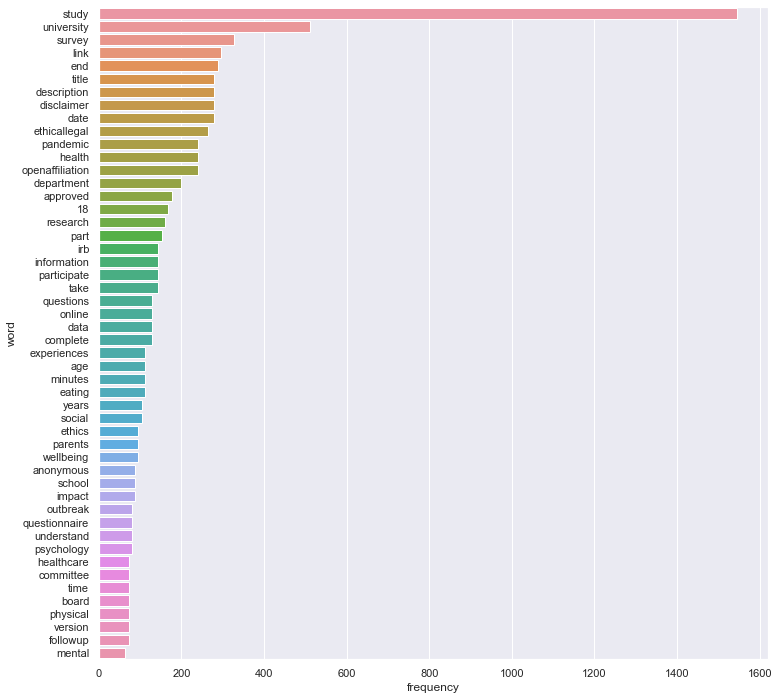

In [10]:
sns.set(style="darkgrid")
counts = Counter(word_list).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df
counts_df.columns = ['word', 'frequency']

fig, ax = plt.subplots(figsize = (12, 12))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)
plt.savefig('wordcount_bar.png')

In [11]:
!pip install wordcloud

In [12]:
from wordcloud import WordCloud

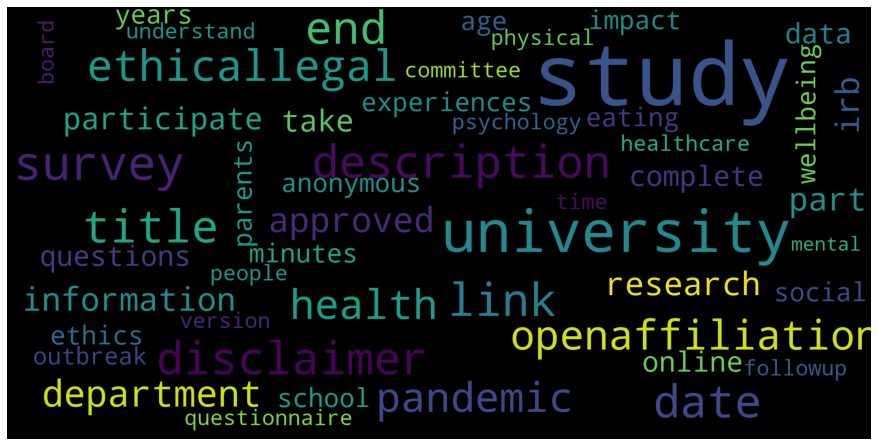

In [13]:
wordcloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(word_list))


plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig('wordcloud.png')

In [14]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lab3_ayhanakkaya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = text_en_lr_lc_pr_sr.apply(lambda x: sid.polarity_scores(x))
sent_scores_df = pd.DataFrame(list(sentiment_scores))
sent_scores_df.tail()

,neg,neu,pos,compound
1603,0.0,1.000,0.000,0.0000
1604,0.0,0.714,0.286,0.5574
1605,0.0,1.000,0.000,0.0000
1606,0.0,0.741,0.259,0.4215
1607,0.0,1.000,0.000,0.0000


In [16]:
sent_scores_df['val'] = sent_scores_df['compound'].apply(lambda x: 'neutral' if x == 0 else ('positive' if x > 0 else 'negative'))
sent_scores_df.head()

,neg,neu,pos,compound,val
0,0.0,1.000,0.000,0.0000,neutral
1,0.0,0.889,0.111,0.6124,positive
2,0.0,1.000,0.000,0.0000,neutral
3,0.0,0.682,0.318,0.4215,positive
4,0.0,1.000,0.000,0.0000,neutral


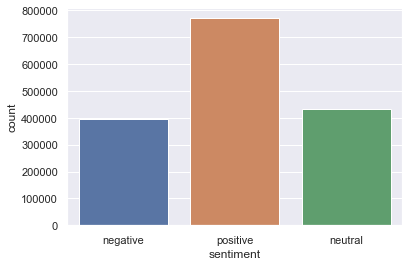

In [24]:
sent_counts = pd.DataFrame.from_dict(Counter(sent_scores_df['val']), orient = 'index').reset_index()
sent_counts.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_counts)
plt.savefig('sentiment.png')

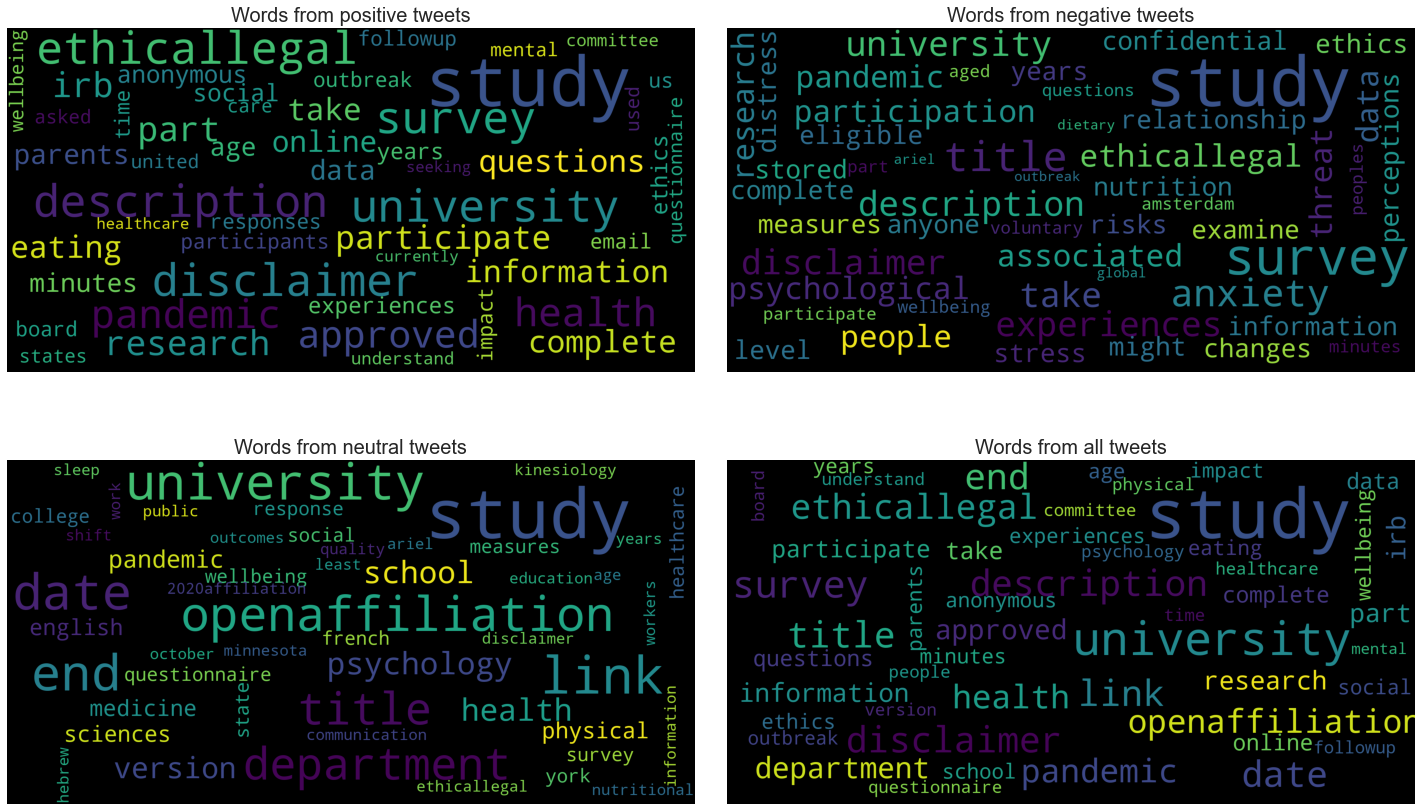

In [27]:
polar_tweets_df = pd.DataFrame()
polar_tweets_df['tweet'] = text_en_lr_lc_pr_sr
polar_tweets_df['polarity'] = sent_scores_df['val']

positive = polar_tweets_df[polar_tweets_df['polarity'] == 'positive']['tweet']
negative = polar_tweets_df[polar_tweets_df['polarity'] == 'negative']['tweet']
neutral = polar_tweets_df[polar_tweets_df['polarity'] == 'neutral']['tweet']

positive_list = [word for line in positive for word in line.split()]
negative_list = [word for line in negative for word in line.split()]
neutral_list = [word for line in neutral for word in line.split()]

positive_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(positive_list))

negative_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(negative_list))

neutral_cloud = WordCloud(
    background_color='black',
    max_words=50,
    max_font_size=40, 
    scale=5,
    random_state=1,
    collocations=False,
    normalize_plurals=False
).generate(' '.join(neutral_list))


fig, axs = plt.subplots(2, 2, figsize = (20, 12))
# fig.suptitle('Clouds of polar words', fontsize = 30)
fig.tight_layout(pad = 0)

axs[0, 0].imshow(positive_cloud)
axs[0, 0].set_title('Words from positive tweets', fontsize = 20)
axs[0, 0].axis('off')
# axs[0, 0].tight_layout(pad = 1)

axs[0, 1].imshow(negative_cloud)
axs[0, 1].set_title('Words from negative tweets', fontsize = 20)
axs[0, 1].axis('off')
# axs[0, 1].tight_layout(pad = 1)

axs[1, 0].imshow(neutral_cloud)
axs[1, 0].set_title('Words from neutral tweets', fontsize = 20)
axs[1, 0].axis('off')
# axs[1, 0].tight_layout(pad = 1)

axs[1, 1].imshow(wordcloud)
axs[1, 1].set_title('Words from all tweets', fontsize = 20)
axs[1, 1].axis('off')
# axs[1, 0].tight_layout(pad = 1)
plt.savefig('joint_cloud.png')